(wrapping_jax_function)=
# How to wrap a JAX function for use in PyMC

:::{post} Mar 24, 2022
:tags: PyTensor, hidden markov model, JAX 
:category: advanced, how-to
:author: Ricardo Vieira
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

from pytensor.graph import Apply, Op

In [2]:
RANDOM_SEED = 104109109
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

:::{include} ../extra_installs.md
:::

In [3]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import pymc.sampling_jax

from pytensor.link.jax.dispatch import jax_funcify

/home/ricardo/miniconda3/envs/pymc-examples/lib/python3.10/site-packages/pytensor/link/jax/dispatch.py:87: UserWarning: JAX omnistaging couldn't be disabled: Disabling of omnistaging is no longer supported in JAX version 0.2.12 and higher: see https://github.com/google/jax/blob/main/design_notes/omnistaging.md.
  warnings.warn(f"JAX omnistaging couldn't be disabled: {e}")
/home/ricardo/Documents/Projects/pymc/pymc/sampling_jax.py:36: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


## Intro: PyTensor and its backends

PyMC uses the {doc}`PyTensor <pytensor:index>` library to create and manipulate probabilistic graphs. PyTensor is backend-agnostic, meaning it can make use of functions written in different languages or frameworks, including pure Python, NumPy, C, Cython, Numba, and [JAX](https://jax.readthedocs.io/en/latest/index.html). 

All that is needed is to encapsulate such function in a PyTensor {class}`~pytensor.graph.op.Op`, which enforces a specific API regarding how inputs and outputs of pure "operations" should be handled. It also implements methods for optional extra functionality like symbolic shape inference and automatic differentiation. This is well covered in the PyTensor {ref}`Op documentation <pytensor:op_contract>` and in our {ref}`blackbox_external_likelihood_numpy` pymc-example.

More recently, PyTensor became capable of compiling directly to some of these languages/frameworks, meaning that we can convert a complete PyTensor graph into a JAX or NUMBA jitted function, whereas traditionally they could only be converted to Python or C.

This has some interesting uses, such as sampling models defined in PyMC with pure JAX samplers, like those implemented in [NumPyro](https://num.pyro.ai/en/latest/index.html) or [BlackJax](https://github.com/blackjax-devs/blackjax). 

This notebook illustrates how we can implement a new PyTensor {class}`~pytensor.graph.op.Op` that wraps a JAX function. 

### Outline

1. We start in a similar path as that taken in the {ref}`blackbox_external_likelihood_numpy`, which wraps a NumPy function in a PyTensor {class}`~pytensor.graph.op.Op`, this time wrapping a JAX jitted function instead. 
2. We then enable PyTensor to "unwrap" the just wrapped JAX function, so that the whole graph can be compiled to JAX. We make use of this to sample our PyMC model via the JAX NumPyro NUTS sampler.

## A motivating example: marginal HMM

For illustration purposes, we will simulate data following a simple [Hidden Markov Model](https://en.wikipedia.org/wiki/Hidden_Markov_model) (HMM), with 3 possible latent states $S \in \{0, 1, 2\}$ and normal emission likelihood.

$$Y \sim \text{Normal}((S + 1) \cdot \text{signal}, \text{noise})$$

Our HMM will have a fixed Categorical probability $P$ of switching across states, which depends only on the last state

$$S_{t+1} \sim \text{Categorical}(P_{S_t})$$

To complete our model, we assume a fixed probability $P_{t0}$ for each possible initial state $S_{t0}$,

$$S_{t0} \sim \text{Categorical}(P_{t0})$$


### Simulating data
Let's generate data according to this model! The first step is to set some values for the parameters in our model

In [4]:
# Emission signal and noise parameters
emission_signal_true = 1.15
emission_noise_true = 0.15

p_initial_state_true = np.array([0.9, 0.09, 0.01])

# Probability of switching from state_t to state_t+1
p_transition_true = np.array(
    [
        #    0,   1,   2
        [0.9, 0.09, 0.01],  # 0
        [0.1, 0.8, 0.1],  # 1
        [0.2, 0.1, 0.7],  # 2
    ]
)

# Confirm that we have defined valid probabilities
assert np.isclose(np.sum(p_initial_state_true), 1)
assert np.allclose(np.sum(p_transition_true, axis=-1), 1)

In [5]:
# Let's compute the log of the probalitiy transition matrix for later use
with np.errstate(divide="ignore"):
    logp_initial_state_true = np.log(p_initial_state_true)
    logp_transition_true = np.log(p_transition_true)

logp_initial_state_true, logp_transition_true

(array([-0.10536052, -2.40794561, -4.60517019]),
 array([[-0.10536052, -2.40794561, -4.60517019],
        [-2.30258509, -0.22314355, -2.30258509],
        [-1.60943791, -2.30258509, -0.35667494]]))

In [6]:
# We will observe 70 HMM processes, each with a total of 50 steps
n_obs = 70
n_steps = 50

We write a helper function to generate a single HMM process and create our simulated data

In [7]:
def simulate_hmm(p_initial_state, p_transition, emission_signal, emission_noise, n_steps, rng):
    """Generate hidden state and emission from our HMM model."""

    possible_states = np.array([0, 1, 2])

    hidden_states = []
    initial_state = rng.choice(possible_states, p=p_initial_state)
    hidden_states.append(initial_state)
    for step in range(n_steps):
        new_hidden_state = rng.choice(possible_states, p=p_transition[hidden_states[-1]])
        hidden_states.append(new_hidden_state)
    hidden_states = np.array(hidden_states)

    emissions = rng.normal(
        (hidden_states + 1) * emission_signal,
        emission_noise,
    )

    return hidden_states, emissions

In [8]:
single_hmm_hidden_state, single_hmm_emission = simulate_hmm(
    p_initial_state_true,
    p_transition_true,
    emission_signal_true,
    emission_noise_true,
    n_steps,
    rng,
)
print(single_hmm_hidden_state)
print(np.round(single_hmm_emission, 2))

[0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 1
 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
[1.34 0.79 1.07 1.25 1.33 0.98 1.97 2.45 2.21 2.19 2.21 2.15 1.24 1.16
 0.78 1.18 1.34 2.21 2.44 2.14 2.15 2.38 2.27 2.33 2.26 2.37 2.45 2.36
 2.35 2.32 2.36 2.21 2.27 2.32 3.68 3.32 2.39 2.14 1.99 1.32 1.15 1.31
 1.25 1.17 1.06 0.91 0.88 1.17 1.   1.01 0.87]


In [9]:
hidden_state_true = []
emission_observed = []

for i in range(n_obs):
    hidden_state, emission = simulate_hmm(
        p_initial_state_true,
        p_transition_true,
        emission_signal_true,
        emission_noise_true,
        n_steps,
        rng,
    )
    hidden_state_true.append(hidden_state)
    emission_observed.append(emission)

hidden_state = np.array(hidden_state_true)
emission_observed = np.array(emission_observed)

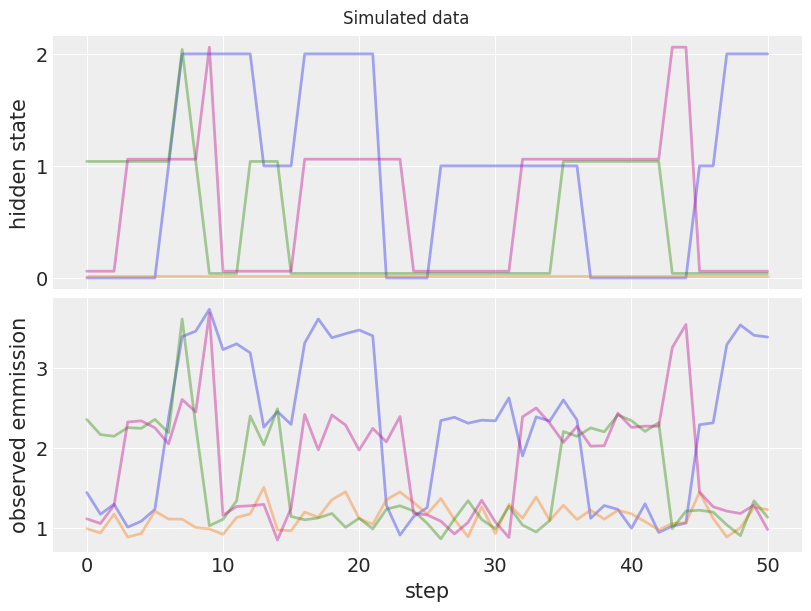

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
# Plot first five hmm processes
for i in range(4):
    ax[0].plot(hidden_state_true[i] + i * 0.02, color=f"C{i}", lw=2, alpha=0.4)
    ax[1].plot(emission_observed[i], color=f"C{i}", lw=2, alpha=0.4)
ax[0].set_yticks([0, 1, 2])
ax[0].set_ylabel("hidden state")
ax[1].set_ylabel("observed emmission")
ax[1].set_xlabel("step")
fig.suptitle("Simulated data");

The figure above shows the hidden state and respective observed emission of our simulated data. Later, we will use this data to perform posterior inferences about the true model parameters.

## Computing the marginal HMM likelihood using JAX

We will write a JAX function to compute the likelihood of our HMM model, marginalizing over the hidden states. This allows for more efficient sampling of the remaining model parameters. To achieve this, we will use the well known [forward algorithm](https://en.wikipedia.org/wiki/Forward_algorithm), working on the log scale for numerical stability.

We will take advantage of JAX [scan](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.scan.html) to obtain an efficient and differentiable log-likelihood, and the handy [vmap](https://jax.readthedocs.io/en/latest/_autosummary/jax.vmap.html#jax.vmap) to automatically vectorize this log-likelihood across multiple observed processes.

Our core JAX function computes the marginal log-likelihood of a single HMM process

In [11]:
def hmm_logp(
    emission_observed,
    emission_signal,
    emission_noise,
    logp_initial_state,
    logp_transition,
):
    """Compute the marginal log-likelihood of a single HMM process."""

    hidden_states = np.array([0, 1, 2])

    # Compute log-likelihood of observed emissions for each (step x possible hidden state)
    logp_emission = jsp.stats.norm.logpdf(
        emission_observed[:, None],
        (hidden_states + 1) * emission_signal,
        emission_noise,
    )

    # We use the forward_algorithm to compute log_alpha(x_t) = logp(x_t, y_1:t)
    log_alpha = logp_initial_state + logp_emission[0]
    log_alpha, _ = jax.lax.scan(
        f=lambda log_alpha_prev, logp_emission: (
            jsp.special.logsumexp(log_alpha_prev + logp_transition.T, axis=-1) + logp_emission,
            None,
        ),
        init=log_alpha,
        xs=logp_emission[1:],
    )

    return jsp.special.logsumexp(log_alpha)

Let's test it with the true parameters and the first simulated HMM process

In [12]:
hmm_logp(
    emission_observed[0],
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

DeviceArray(-3.93533794, dtype=float64)

We now use vmap to vectorize the core function across multiple observations.

In [13]:
def vec_hmm_logp(*args):
    vmap = jax.vmap(
        hmm_logp,
        # Only the first argument, needs to be vectorized
        in_axes=(0, None, None, None, None),
    )
    # For simplicity we sum across all the HMM processes
    return jnp.sum(vmap(*args))


# We jit it for better performance!
jitted_vec_hmm_logp = jax.jit(vec_hmm_logp)

Passing a row matrix with only the first simulated HMM process should return the same result

In [14]:
jitted_vec_hmm_logp(
    emission_observed[0][None, :],
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

DeviceArray(-3.93533794, dtype=float64)

Our goal is, however, to compute the joint log-likelihood for all the simulated data

In [15]:
jitted_vec_hmm_logp(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)

DeviceArray(-37.00348857, dtype=float64)

We will also ask JAX to give us the function of the gradients with respect to each input. This will come in handy later.

In [16]:
jitted_vec_hmm_logp_grad = jax.jit(jax.grad(vec_hmm_logp, argnums=list(range(5))))

Let's print out the gradient with respect to `emission_signal`. We will check this value is unchanged after we wrap our function in PyTensor.

In [17]:
jitted_vec_hmm_logp_grad(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)[1]

DeviceArray(-297.86490611, dtype=float64, weak_type=True)

## Wrapping the JAX function in PyTensor

Now we are ready to wrap our JAX jitted function in a PyTensor {class}`~pytensor.graph.op.Op`, that we can then use in our PyMC models. We recommend you check PyTensor's official {ref}`Op documentation <pytensor:op_contract>` if you want to understand it in more detail.

In brief, we will inherit from {class}`~pytensor.graph.op.Op` and define the following methods:
1. `make_node`: Creates an {class}`~pytensor.graph.basic.Apply` node that holds together the symbolic inputs and outputs of our operation
2. `perform`: Python code that returns the evaluation of our operation, given concrete input values
3. `grad`: Returns a PyTensor symbolic graph that represents the gradient expression of an output cost wrt to its inputs

For the `grad` we will create a second {class}`~pytensor.graph.op.Op` that wraps our jitted grad version from above

In [18]:
class HMMLogpOp(Op):
    def make_node(
        self,
        emission_observed,
        emission_signal,
        emission_noise,
        logp_initial_state,
        logp_transition,
    ):
        # Convert our inputs to symbolic variables
        inputs = [
            pt.as_tensor_variable(emission_observed),
            pt.as_tensor_variable(emission_signal),
            pt.as_tensor_variable(emission_noise),
            pt.as_tensor_variable(logp_initial_state),
            pt.as_tensor_variable(logp_transition),
        ]
        # Define the type of the output returned by the wrapped JAX function
        outputs = [pt.dscalar()]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result = jitted_vec_hmm_logp(*inputs)
        # PyTensor raises an error if the dtype of the returned output is not
        # exactly the one expected from the Apply node (in this case
        # `dscalar`, which stands for float64 scalar), so we make sure
        # to convert to the expected dtype. To avoid unnecessary conversions
        # you should make sure the expected output defined in `make_node`
        # is already of the correct dtype
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)

    def grad(self, inputs, output_gradients):
        (
            grad_wrt_emission_obsered,
            grad_wrt_emission_signal,
            grad_wrt_emission_noise,
            grad_wrt_logp_initial_state,
            grad_wrt_logp_transition,
        ) = hmm_logp_grad_op(*inputs)
        # If there are inputs for which the gradients will never be needed or cannot
        # be computed, `pytensor.gradient.grad_not_implemented` should  be used as the
        # output gradient for that input.
        output_gradient = output_gradients[0]
        return [
            output_gradient * grad_wrt_emission_obsered,
            output_gradient * grad_wrt_emission_signal,
            output_gradient * grad_wrt_emission_noise,
            output_gradient * grad_wrt_logp_initial_state,
            output_gradient * grad_wrt_logp_transition,
        ]


class HMMLogpGradOp(Op):
    def make_node(
        self,
        emission_observed,
        emission_signal,
        emission_noise,
        logp_initial_state,
        logp_transition,
    ):
        inputs = [
            pt.as_tensor_variable(emission_observed),
            pt.as_tensor_variable(emission_signal),
            pt.as_tensor_variable(emission_noise),
            pt.as_tensor_variable(logp_initial_state),
            pt.as_tensor_variable(logp_transition),
        ]
        # This `Op` will return one gradient per input. For simplicity, we assume
        # each output is of the same type as the input. In practice, you should use
        # the exact dtype to avoid overhead when saving the results of the computation
        # in `perform`
        outputs = [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        (
            grad_wrt_emission_obsered_result,
            grad_wrt_emission_signal_result,
            grad_wrt_emission_noise_result,
            grad_wrt_logp_initial_state_result,
            grad_wrt_logp_transition_result,
        ) = jitted_vec_hmm_logp_grad(*inputs)
        outputs[0][0] = np.asarray(grad_wrt_emission_obsered_result, dtype=node.outputs[0].dtype)
        outputs[1][0] = np.asarray(grad_wrt_emission_signal_result, dtype=node.outputs[1].dtype)
        outputs[2][0] = np.asarray(grad_wrt_emission_noise_result, dtype=node.outputs[2].dtype)
        outputs[3][0] = np.asarray(grad_wrt_logp_initial_state_result, dtype=node.outputs[3].dtype)
        outputs[4][0] = np.asarray(grad_wrt_logp_transition_result, dtype=node.outputs[4].dtype)


# Initialize our `Op`s
hmm_logp_op = HMMLogpOp()
hmm_logp_grad_op = HMMLogpGradOp()

We recommend using the debug helper `eval` method to confirm we specified everything correctly. We should get the same outputs as before:

In [19]:
hmm_logp_op(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
).eval()

array(-37.00348857)

In [20]:
hmm_logp_grad_op(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)[1].eval()

array(-297.86490611)

It's also useful to check the gradient of our {class}`~pytensor.graph.op.Op` can be requested via the PyTensor `grad` interface:

In [21]:
# We define the symbolic `emission_signal` variable outside of the `Op`
# so that we can request the gradient wrt to it
emission_signal_variable = pt.as_tensor_variable(emission_signal_true)
x = hmm_logp_op(
    emission_observed,
    emission_signal_variable,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)
x_grad_wrt_emission_signal = pt.grad(x, wrt=emission_signal_variable)
x_grad_wrt_emission_signal.eval()

array(-297.86490611)

### Sampling with PyMC

We are now ready to make inferences about our HMM model with PyMC. We will define priors for each model parameter and use {class}`~pymc.Potential` to add the joint log-likelihood term to our model.

In [22]:
with pm.Model(rng_seeder=int(rng.integers(2**30))) as model:
    emission_signal = pm.Normal("emission_signal", 0, 1)
    emission_noise = pm.HalfNormal("emission_noise", 1)

    p_initial_state = pm.Dirichlet("p_initial_state", np.ones(3))
    logp_initial_state = pt.log(p_initial_state)

    p_transition = pm.Dirichlet("p_transition", np.ones(3), size=3)
    logp_transition = pt.log(p_transition)

    loglike = pm.Potential(
        "hmm_loglike",
        hmm_logp_op(
            emission_observed,
            emission_signal,
            emission_noise,
            logp_initial_state,
            logp_transition,
        ),
    )

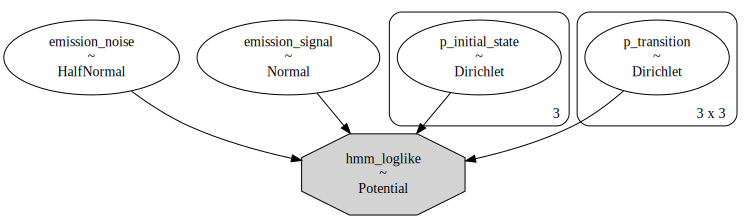

In [23]:
pm.model_to_graphviz(model)

Before we start sampling, we check the logp of each variable at the model initial point. Bugs tend to manifest themselves in the form of `nan` or `-inf` for the initial probabilities.

In [24]:
initial_point = model.compute_initial_point()
initial_point

{'emission_signal': array(0.),
 'emission_noise_log__': array(0.),
 'p_initial_state_simplex__': array([0., 0.]),
 'p_transition_simplex__': array([[0., 0.],
        [0., 0.],
        [0., 0.]])}

In [25]:
model.point_logps(initial_point)

{'emission_signal': -0.92,
 'emission_noise': -0.73,
 'p_initial_state': -1.5,
 'p_transition': -4.51,
 'hmm_loglike': -9812.67}

We are now ready to sample!

In [26]:
with model:
    idata = pm.sample(chains=2, cores=1)

Auto-assigning NUTS sampler...
INFO:pymc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc:Initializing NUTS using jitter+adapt_diag...
/home/ricardo/Documents/Projects/pymc/pymc/pytensorf.py:1005: UserWarning: The parameter 'updates' of pytensor.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  pytensor_function = pytensor.function(
Sequential sampling (2 chains in 1 job)
INFO:pymc:Sequential sampling (2 chains in 1 job)
NUTS: [emission_signal, emission_noise, p_initial_state, p_transition]
INFO:pymc:NUTS: [emission_signal, emission_noise, p_initial_state, p_transition]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
INFO:pymc:Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.


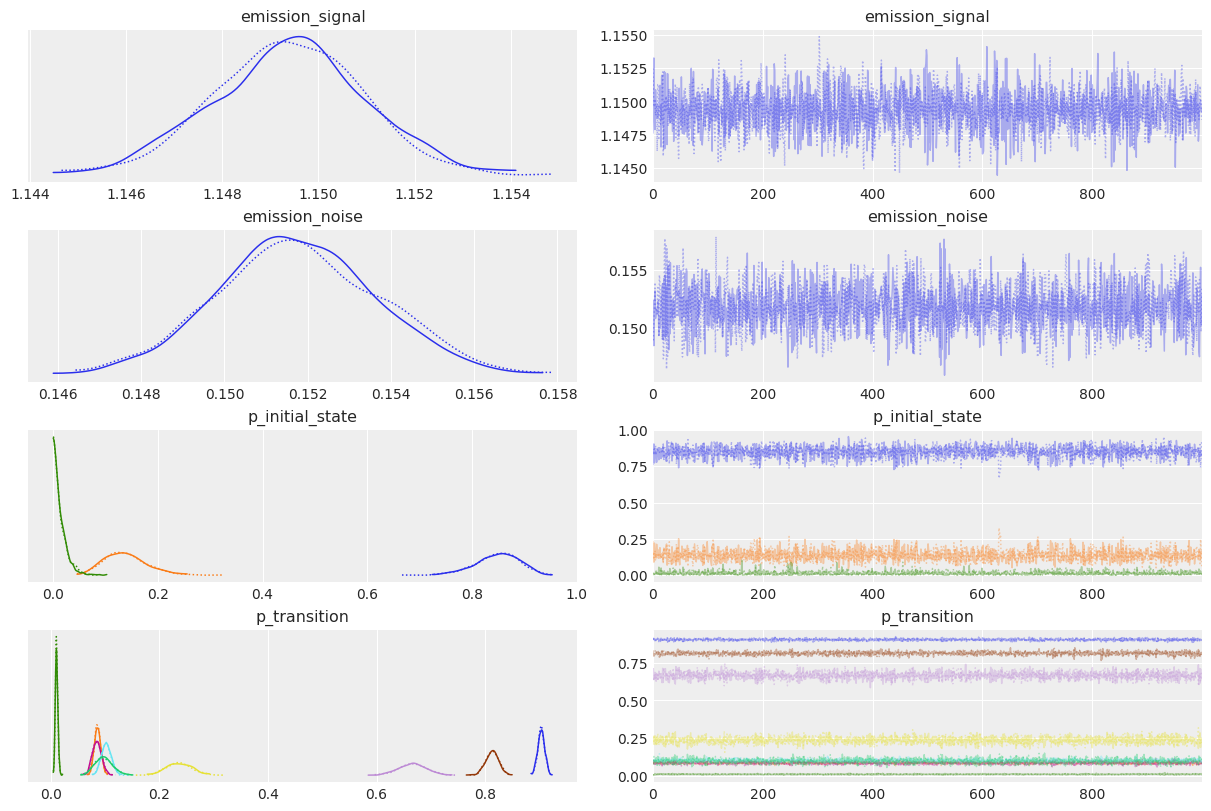

In [27]:
az.plot_trace(idata);

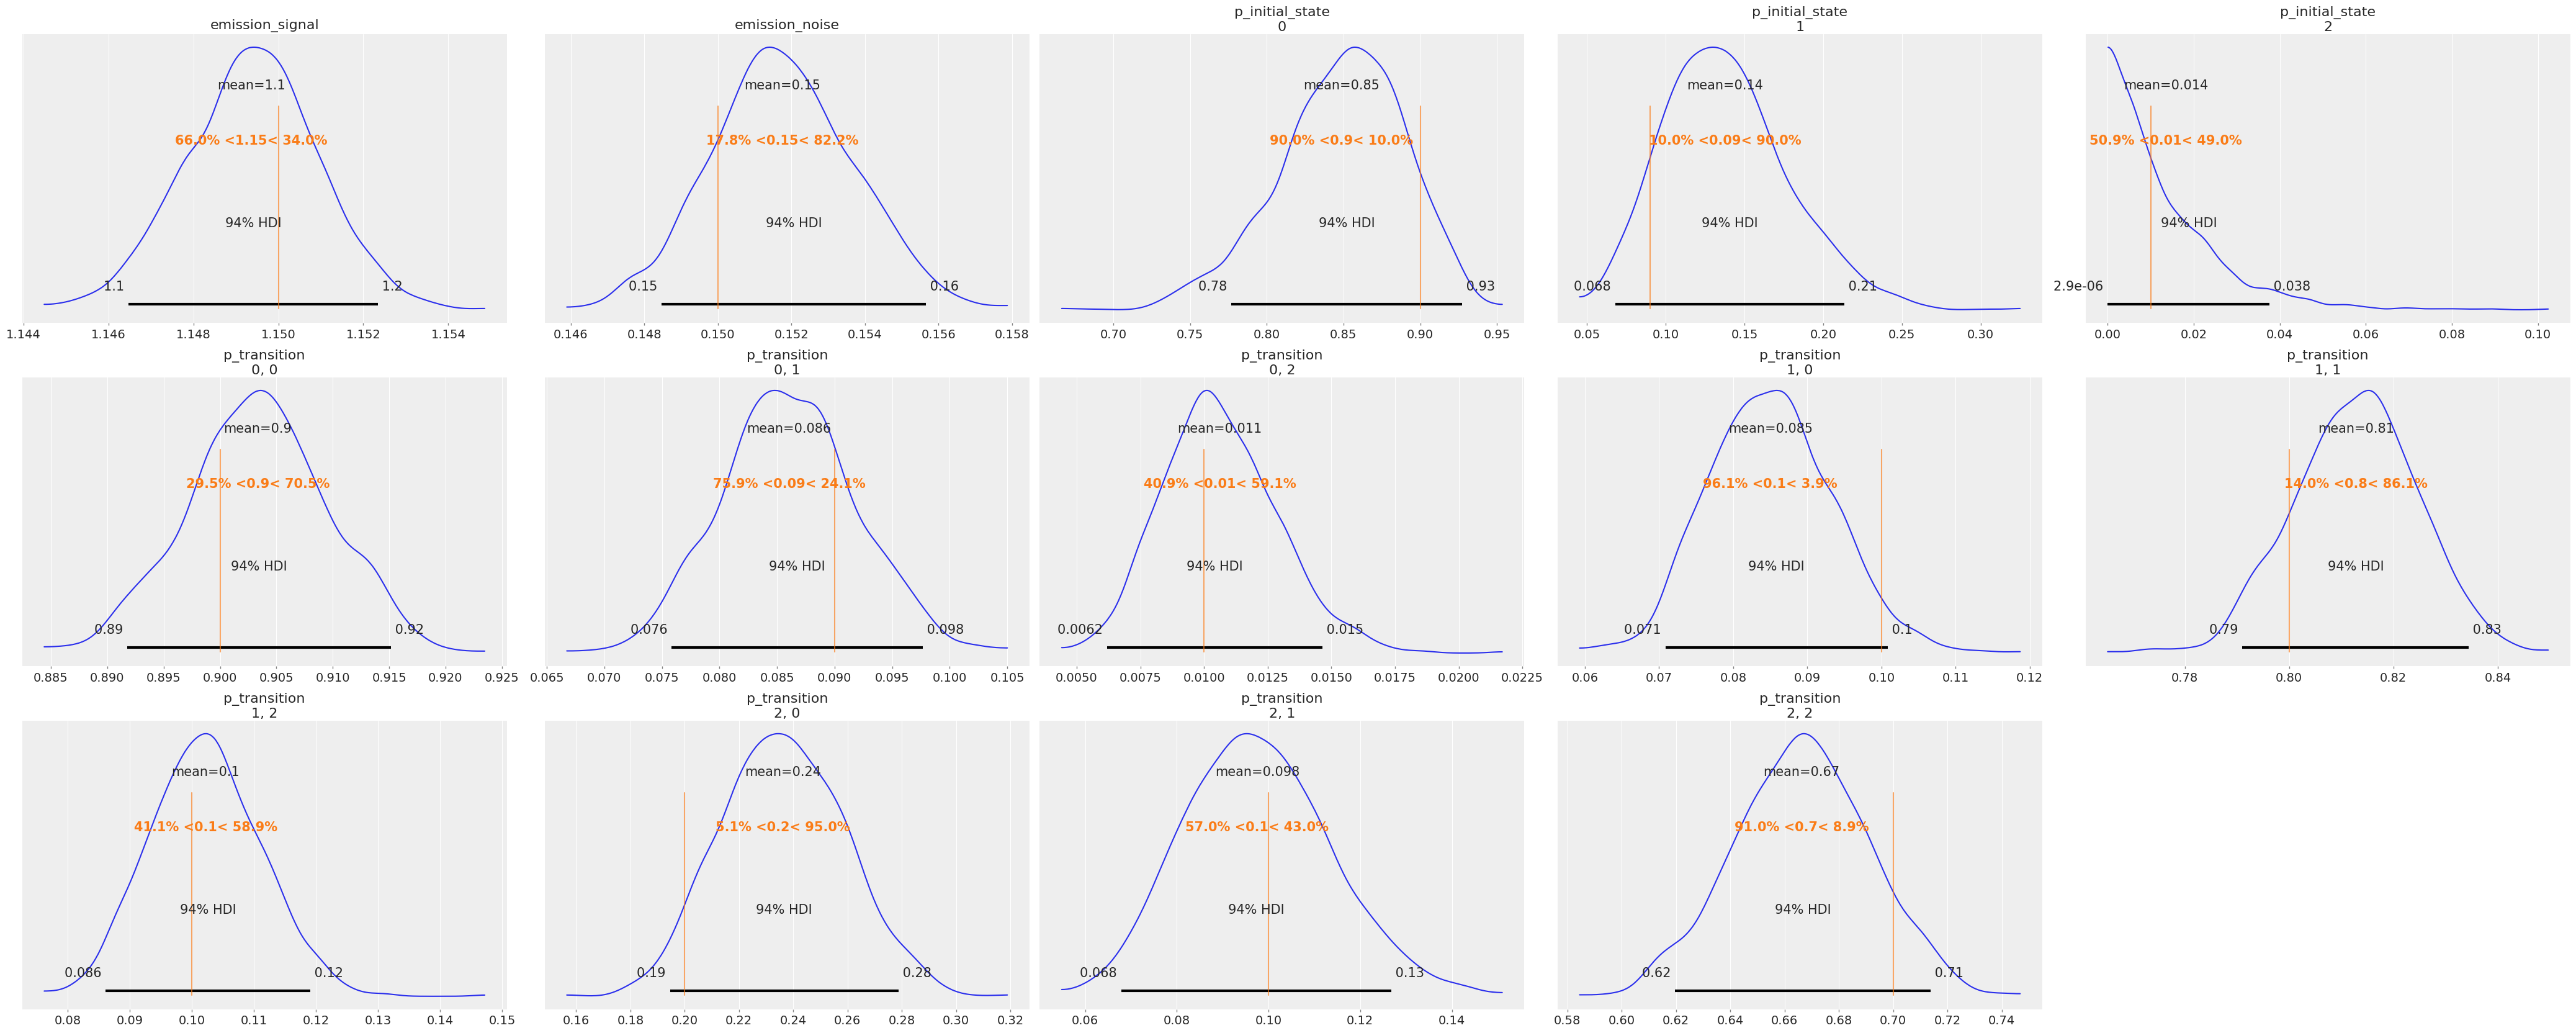

In [28]:
true_values = [
    emission_signal_true,
    emission_noise_true,
    *p_initial_state_true,
    *p_transition_true.ravel(),
]

az.plot_posterior(idata, ref_val=true_values, grid=(3, 5));

The posteriors look reasonably centered around the true values used to generate our data.

## Unwrapping the wrapped JAX function

As mentioned in the beginning, PyTensor can compile an entire graph to JAX. To do this, it needs to know how each {class}`~pytensor.graph.op.Op` in the graph can be converted to a JAX function. This can be done by {term}`dispatch <dispatching>` with {func}`pytensor.link.jax.dispatch.jax_funcify`. Most of the default PyTensor {class}`~pytensor.graph.op.Op`s already have such a dispatch function, but we will need to add a new one for our custom `HMMLogpOp`, as PyTensor has never seen that before.

For that we need a function which returns (another) JAX function, that performs the same computation as in our `perform` method. Fortunately, we started exactly with such function, so this amounts to 3 short lines of code.

In [29]:
@jax_funcify.register(HMMLogpOp)
def hmm_logp_dispatch(op, **kwargs):
    return vec_hmm_logp

:::{note}
We do not return the jitted function, so that the entire PyTensor graph can be jitted together after being converted to JAX.
:::

For a better understanding of {class}`~pytensor.graph.op.Op` JAX conversions, we recommend reading PyTensor's {doc}`Adding JAX and Numba support for Ops guide <pytensor:extending/creating_a_numba_jax_op>`.

We can test that our conversion function is working properly by compiling a {func}`pytensor.function` with `mode="JAX"`:

In [30]:
out = hmm_logp_op(
    emission_observed,
    emission_signal_true,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)
jax_fn = pytensor.function(inputs=[], outputs=out, mode="JAX")
jax_fn()

DeviceArray(-37.00348857, dtype=float64)

We can also compile a JAX function that computes the log probability of each variable in our PyMC model, similar to {meth}`~pymc.Model.point_logps`. We will use the helper method {meth}`~pymc.Model.compile_fn`.

In [31]:
model_logp_jax_fn = model.compile_fn(model.logpt(sum=False), mode="JAX")
model_logp_jax_fn(initial_point)

[DeviceArray(-0.91893853, dtype=float64),
 DeviceArray(-0.72579135, dtype=float64),
 DeviceArray(-1.5040774, dtype=float64),
 DeviceArray([-1.5040774, -1.5040774, -1.5040774], dtype=float64),
 DeviceArray(-9812.66649064, dtype=float64)]

Note that we could have added an equally simple function to convert our `HMMLogpGradOp`, in case we wanted to convert PyTensor gradient graphs to JAX. In our case, we don't need to do this because we will rely on JAX `grad` function (or more precisely, NumPyro will rely on it) to obtain these again from our compiled JAX function.

We include a {ref}`short discussion <pytensor_vs_jax>` at the end of this document, to help you better understand the trade-offs between working with PyTensor graphs vs JAX functions, and when you might want to use one or the other.

### Sampling with NumPyro

Now that we know our model logp can be entirely compiled to JAX, we can use the handy {func}`pymc.sampling_jax.sample_numpyro_nuts` to sample our model using the pure JAX sampler implemented in NumPyro.

In [32]:
with model:
    idata_numpyro = pm.sampling_jax.sample_numpyro_nuts(chains=2, progress_bar=False)

/home/ricardo/miniconda3/envs/pymc-examples/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ricardo/Documents/Projects/pymc/pymc/pytensorf.py:1005: UserWarning: The parameter 'updates' of pytensor.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  pytensor_function = pytensor.function(


Compiling...
Compilation time =  0:00:01.897853
Sampling...
Sampling time =  0:00:47.542330
Transforming variables...
Transformation time =  0:00:00.399051


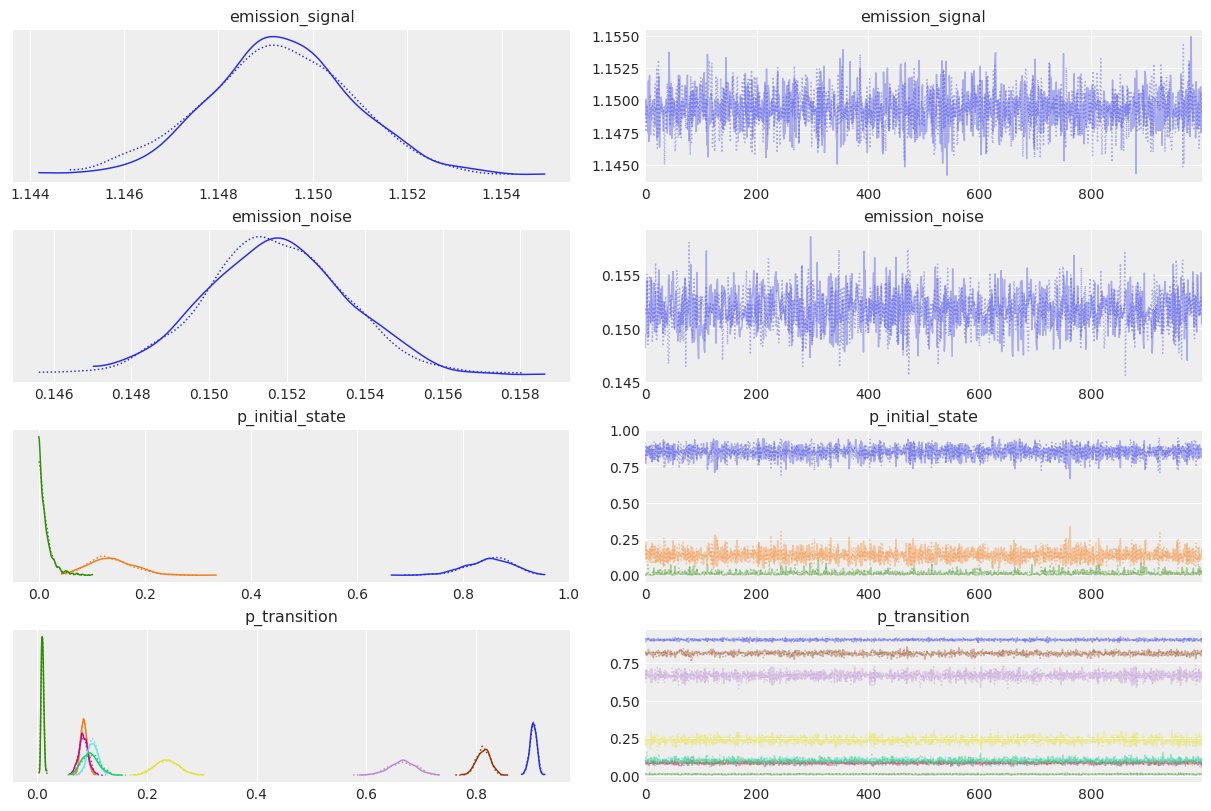

In [33]:
az.plot_trace(idata_numpyro);

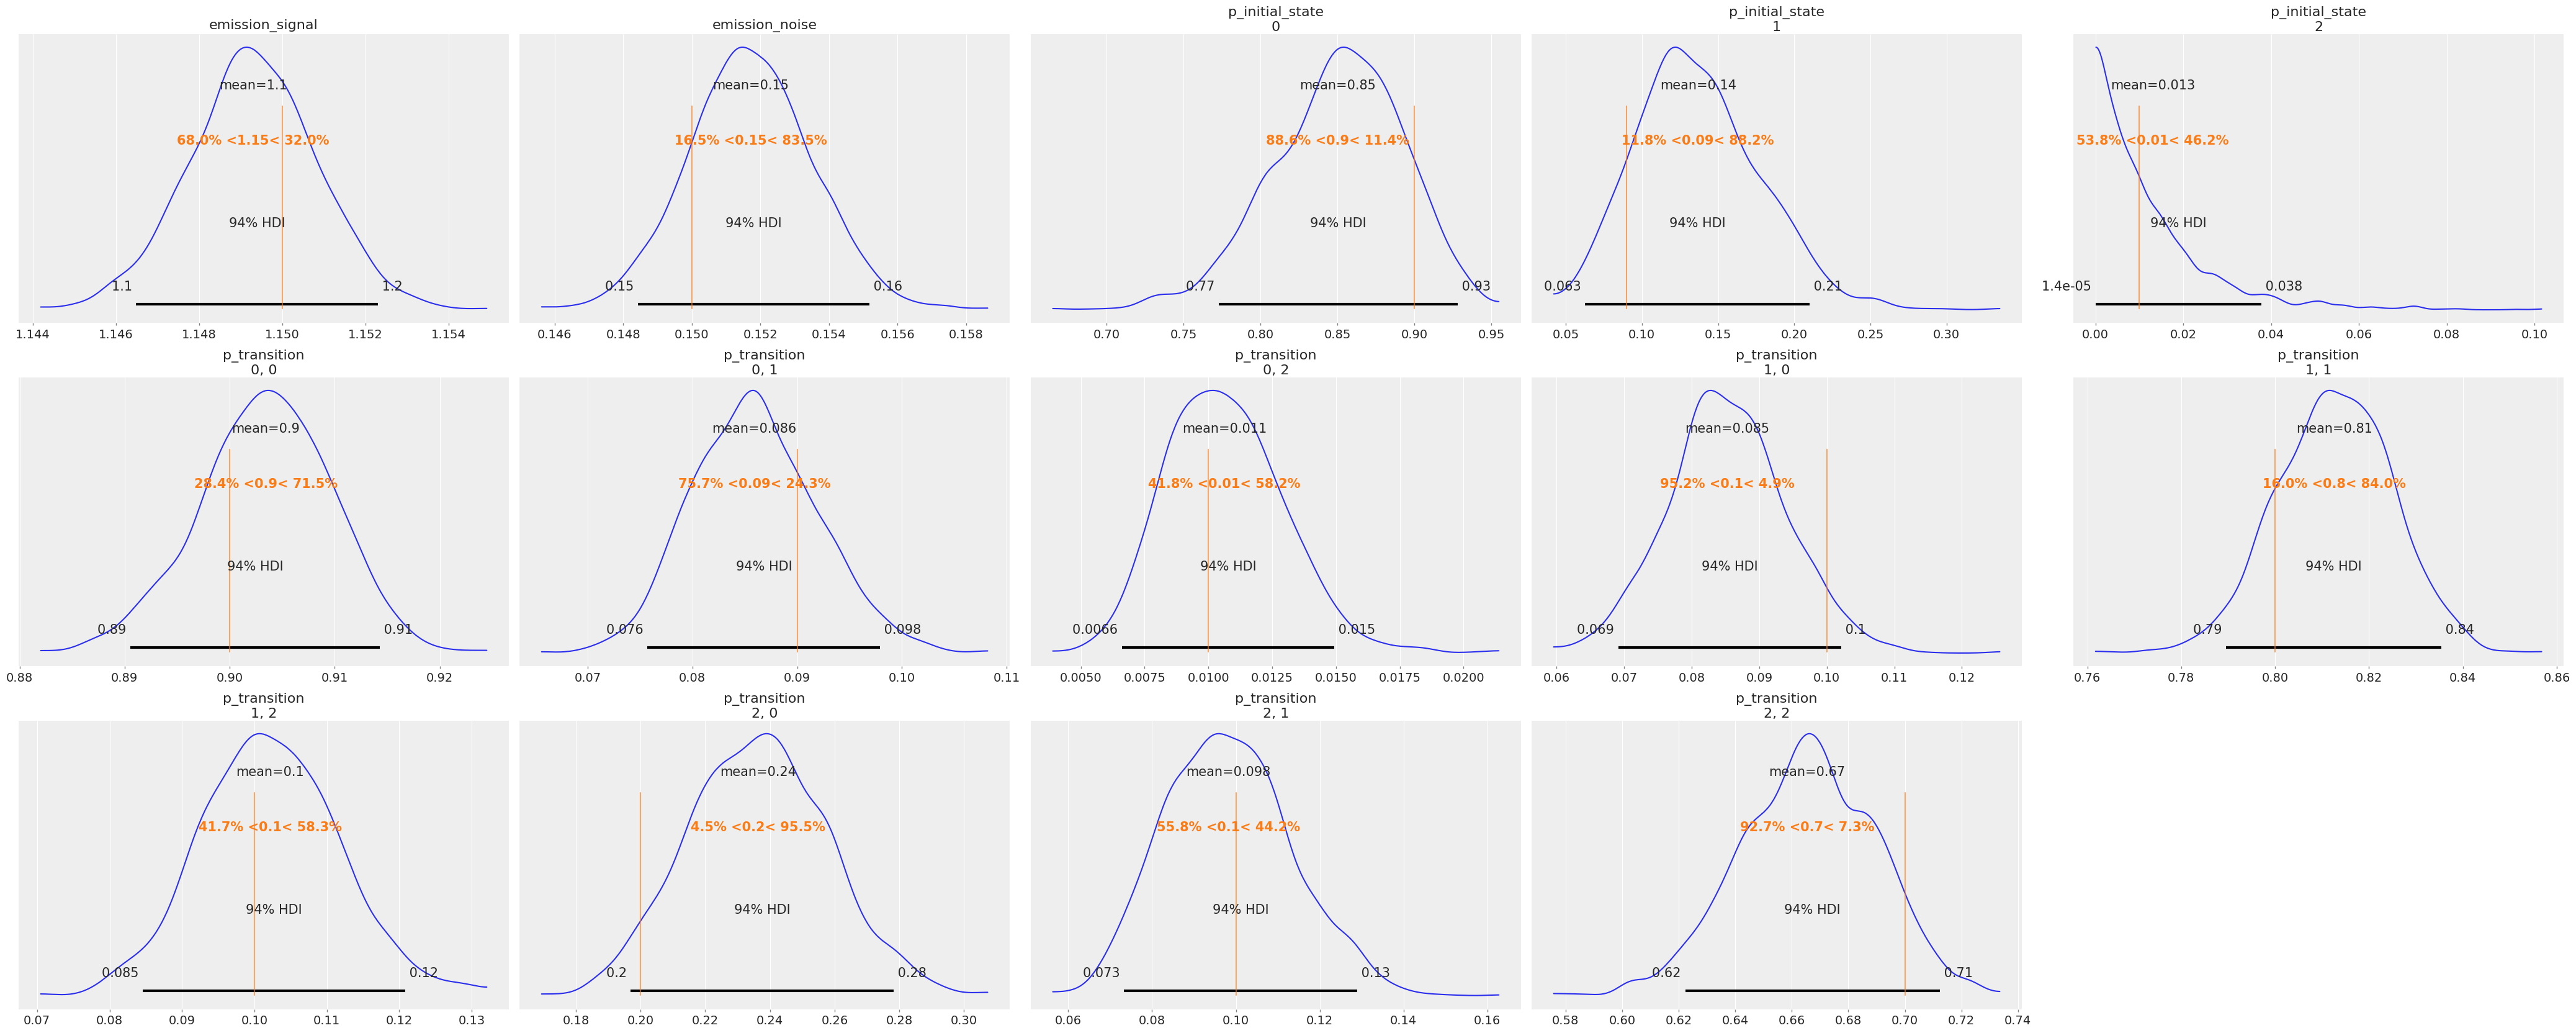

In [34]:
az.plot_posterior(idata_numpyro, ref_val=true_values, grid=(3, 5));

As expected, sampling results look pretty similar! 

Depending on the model and computer architecture you are using, a pure JAX sampler can provide considerable speedups.

(pytensor_vs_jax)=
## Some brief notes on using PyTensor vs JAX

### When should you use JAX?

As we have seen, it is pretty straightforward to interface between PyTensor graphs and JAX functions. 

This can be very handy when you want to combine previously implemented JAX function with PyMC models. We used a marginalized HMM log-likelihood in this example, but the same strategy could be used to do Bayesian inference with Deep Neural Networks or Differential Equations, or pretty much any other functions implemented in JAX that can be used in the context of a Bayesian model.

It can also be worth it, if you need to make use of JAX's unique features like vectorization, support for tree structures, or its fine-grained parallelization, and GPU and TPU capabilities.

### When should you not use JAX?

Like JAX, PyTensor has the goal of mimicking the NumPy and Scipy APIs, so that writing code in PyTensor should feel very similar to how code is written in those libraries.

There are, however, some of advantages to working with PyTensor:

1. PyTensor graphs are considerably easier to {ref}`inspect and debug <pytensor:debug_faq>` than JAX functions
2. PyTensor has clever {ref}`optimization and stabilization routines <pytensor:optimizations>` that are not possible or implemented in JAX
3. PyTensor graphs can be easily {ref}`manipulated after creation <pytensor:graph_rewriting>`

Point 2 means your graphs are likely to perform better if written in PyTensor. In general you don't have to worry about using specialized functions like `log1p` or `logsumexp`, as PyTensor will be able to detect the equivalent naive expressions and replace them by their specialized counterparts. Importantly, you still benefit from these optimizations when your graph is later compiled to JAX.

The catch is that PyTensor cannot reason about JAX functions, and by association {class}`~pytensor.graph.op.Op`s that wrap them. This means that the larger the portion of the graph is "hidden" inside a JAX function, the less a user will benefit from PyTensor's rewrite and debugging abilities.

Point 3 is more important for library developers. It is the main reason why PyMC developers opted to use PyTensor (and before that, its predecessor Theano) as its backend. Many of the user-facing utilities provided by PyMC rely on the ability to easily parse and manipulate PyTensor graphs.

## Bonus: Using a single Op that can compute its own gradients

We had to create two {class}`~pytensor.graph.op.Op`s, one for the function we cared about and a separate one for its gradients. However, JAX provides a `value_and_grad` utility that can return both the value of a function and its gradients. We can do something similar and get away with a single {class}`~pytensor.graph.op.Op` if we are clever about it.

By doing this we can (potentially) save memory and reuse computation that is shared between the function and its gradients. This may be relevant when working with very large JAX functions.

Note that this is only useful if you are interested in taking gradients with respect to your {class}`~pytensor.graph.op.Op` using PyTensor. If your endgoal is to compile your graph to JAX, and only then take the gradients (as NumPyro does), then it's better to use the first approach. You don't even need to implement the `grad` method and associated {class}`~pytensor.graph.op.Op` in that case.

In [35]:
jitted_hmm_logp_value_and_grad = jax.jit(jax.value_and_grad(vec_hmm_logp, argnums=list(range(5))))

In [36]:
class HmmLogpValueGradOp(Op):
    # By default only show the first output, and "hide" the other ones
    default_output = 0

    def make_node(self, *inputs):
        inputs = [pt.as_tensor_variable(inp) for inp in inputs]
        # We now have one output for the function value, and one output for each gradient
        outputs = [pt.dscalar()] + [inp.type() for inp in inputs]
        return Apply(self, inputs, outputs)

    def perform(self, node, inputs, outputs):
        result, grad_results = jitted_hmm_logp_value_and_grad(*inputs)
        outputs[0][0] = np.asarray(result, dtype=node.outputs[0].dtype)
        for i, grad_result in enumerate(grad_results, start=1):
            outputs[i][0] = np.asarray(grad_result, dtype=node.outputs[i].dtype)

    def grad(self, inputs, output_gradients):
        # The `Op` computes its own gradients, so we call it again.
        value = self(*inputs)
        # We hid the gradient outputs by setting `default_update=0`, but we
        # can retrieve them anytime by accessing the `Apply` node via `value.owner`
        gradients = value.owner.outputs[1:]

        # Make sure the user is not trying to take the gradient with respect to
        # the gradient outputs! That would require computing the second order
        # gradients
        assert all(
            isinstance(g.type, pytensor.gradient.DisconnectedType) for g in output_gradients[1:]
        )

        return [output_gradients[0] * grad for grad in gradients]


hmm_logp_value_grad_op = HmmLogpValueGradOp()

We check again that we can take the gradient using PyTensor `grad` interface

In [37]:
emission_signal_variable = pt.as_tensor_variable(emission_signal_true)
# Only the first output is assigned to the variable `x`, due to `default_output=0`
x = hmm_logp_value_grad_op(
    emission_observed,
    emission_signal_variable,
    emission_noise_true,
    logp_initial_state_true,
    logp_transition_true,
)
pt.grad(x, emission_signal_variable).eval()

array(-297.86490611)

## Authors

Authored by [Ricardo Vieira](https://github.com/ricardoV94/) in March 24, 2022 ([pymc-examples#302](https://github.com/pymc-devs/pymc-examples/pull/302))

## Watermark

In [38]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,aeppl,xarray

Last updated: Mon Apr 11 2022

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.1.1

pytensor: 2.5.1
aeppl : 0.0.27
xarray: 2022.3.0

matplotlib: 3.5.1
jax       : 0.3.4
pytensor    : 2.5.1
arviz     : 0.12.0
pymc      : 4.0.0b6
numpy     : 1.22.3

Watermark: 2.3.0



:::{include} ../page_footer.md
:::